In [15]:
from __future__ import print_function
import logging
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
import torch.nn.functional as F
from PIL import Image
import torch.optim as optim
import os
from os import listdir
import random
import copy
from torch.utils.data import DataLoader
from skimage import measure #supports video also
import pickle
from scipy.spatial import distance
import time
import platform
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import math
import numpy as np
from PIL import Image
import copy
import logging
import time
import sys
sys.path.append('..')
# sys.path.append(path.join(path.dirname(__file__), '..'))
from utils.io import imshow
from utils.io import figure_save
from utils.Network import Network
from utils.Analyser import Analyser
from utils.io import save_network, save, load, figure_save, load_network, make_folder_results, imshow
from utils.format import hex_str2bool
from utils.WaveDataset import create_datasets, transformVar

logging.basicConfig(format='%(message)s',level=logging.INFO)
channels=1
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

nr_net = 0 

version = nr_net + 10
network_type = "ConvAE_LSTM_2/"

if 'Darwin' in platform.system():
    data_dir = '../'
else:
    data_dir = '/disk/scratch/s1680171/wave_propagation/'

if not os.path.isdir("../Results"):
    os.mkdir("../Results")
results_dir = "../Results/" + network_type 

if not os.path.isdir(results_dir):
    make_folder_results(results_dir)
    
# Data
filename_data = results_dir + "all_data.pickle"
if os.path.isfile(filename_data):
    logging.info('Loading datasets')
    all_data = load(filename_data)
    train_dataset = all_data["Training data"]
    val_dataset = all_data["Validation data"]
    test_dataset = all_data["Testing data"]
else:
    logging.info('Creating new datasets')
    test_dataset, val_dataset, train_dataset = create_datasets(
         data_dir+"Video_Data/", transformVar, test_fraction=0.15, validation_fraction=0.15, check_bad_data=False, channels=channels)
    all_data = {"Training data": train_dataset, "Validation data": val_dataset, "Testing data": test_dataset}
    save(all_data, filename_data)

Loading datasets


In [16]:
train_dataset.root_dir = '../Video_Data/'
val_dataset.root_dir = '../Video_Data/'
test_dataset.root_dir = '../Video_Data/'

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=12)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=12)

model = Network(device, channels)
model = load_network(model, device, results_dir+"model.pt")

In [17]:
from utils.training import test
from utils.Scorekeeper import Scorekeeper
from utils.training import initial_input, reinsert, propagate

In [18]:
# test(model, test_dataloader, starting_point, num_input_frames, num_output_frames, 
#      channels, device, score_keeper, results_dir, plot=True, debug=True)
# score_keeper.plot(results_dir)

In [19]:
from IPython.core.debugger import set_trace

test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=1)
starting_point = 0
score_keeper=Scorekeeper(results_dir,1)
num_input_frames = 5
num_output_frames = 10
starting_point = 15

In [20]:
# batch = next(iter(test_dataloader))
# batch_images=batch['image']

In [21]:
plot=False
debug=False

In [22]:
# seed_everything(seed=12345)
# test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, num_workers=1)
# starting_point = 0
# score_keeper=Scorekeeper()
# plot=True
# debug=True

# test(model, test_dataloader, starting_point, num_input_frames, num_output_frames, 
#      channels, device, score_keeper, results_dir, plot=plot, debug=debug)
# score_keeper.plot(results_dir)

In [23]:
score_keeper2 = Scorekeeper(results_dir,1)

In [24]:
model.eval()
total = 0
image_to_plot = 1 # random.randint(0, 15)
reinsert_frequency = 10
training = False

for batch_num, batch in enumerate(test_dataloader):
    batch_images = batch["image"]
    batch_size = batch_images.size()[0]
    model.reset_hidden(batch_size=batch_images.size()[0], training=False)

    total_frames = batch_images.size()[1]
    num_future_frames = total_frames - (starting_point + num_input_frames)
    for future_frame_idx in range(num_future_frames):
        if future_frame_idx == 0:
            prop_type = 'Initial input'
            input_frames = batch_images[:, starting_point * channels:(starting_point + num_input_frames) * channels, :, :].clone()
            output_frames, target_frames = initial_input(model, input_frames, batch_images, starting_point, num_input_frames, channels, device, training)
        elif (future_frame_idx+1)%reinsert_frequency == 0:
            prop_type = 'Reinsert'
            input_frames = output_frames[:, -num_input_frames * channels:, :, :].clone()
            output_frames, target_frames = reinsert(model, input_frames, output_frames, target_frames, batch_images, 
                                                            starting_point, num_input_frames, future_frame_idx, channels, device, training)
        else:
            prop_type = 'Propagate'
            output_frames, target_frames = propagate(model, output_frames, target_frames, batch_images, 
                                                          starting_point, num_input_frames, future_frame_idx,
                                                          channels, device, training)
            # output & target_frames size is [batches, channels * (n + 1), 128, 128]

#         if debug:
#             print('batch_num %d\tfuture_frame_idx %d\ttype %s' % (batch_num, future_frame_idx, prop_type))
#             print(output_frames.size(), target_frames.size())

        for ba in range(output_frames.size()[0]):
            score_keeper.add(output_frames[ba, -channels:, :, :].cpu(), 
                             target_frames[ba, -channels:, :, :].cpu(), 
                             future_frame_idx,"pHash", "pHash2", "SSIM", "Own", "RMSE")

        for ba in range(output_frames.size()[0]):
            score_keeper2.add(target_frames[ba-1, -channels:, :, :].cpu(), 
                             target_frames[ba, -channels:, :, :].cpu(), 
                             future_frame_idx,"pHash", "pHash2", "SSIM", "Own", "RMSE")
        if plot:
            plot_predictions()
            plot_cutthrough()

    logging.info("{:d} out of {:d}".format(batch_num + 1, len(test_dataloader)))
    if debug: break

1 out of 31
2 out of 31
3 out of 31
4 out of 31
5 out of 31
6 out of 31
7 out of 31
8 out of 31
9 out of 31
10 out of 31
11 out of 31
12 out of 31
13 out of 31
14 out of 31
15 out of 31
16 out of 31
17 out of 31
18 out of 31
19 out of 31
20 out of 31
21 out of 31
22 out of 31
23 out of 31
24 out of 31
25 out of 31
26 out of 31
27 out of 31
28 out of 31
29 out of 31
30 out of 31
31 out of 31


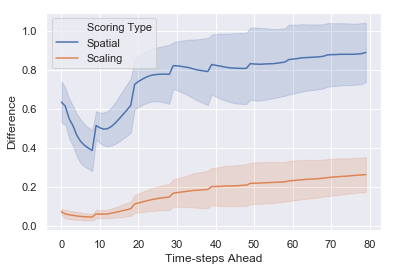

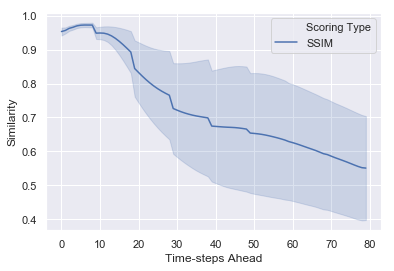

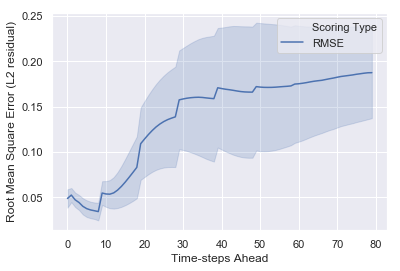

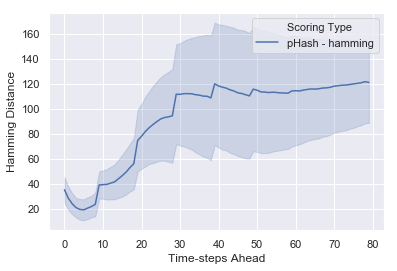

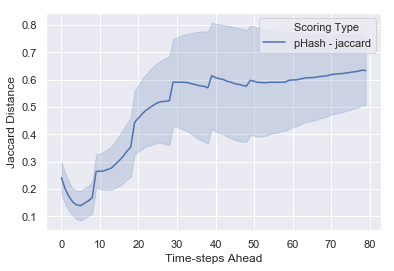

In [25]:
score_keeper.plot()

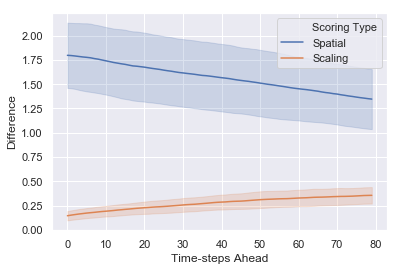

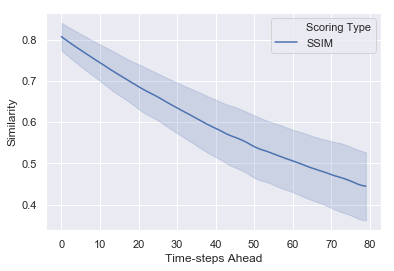

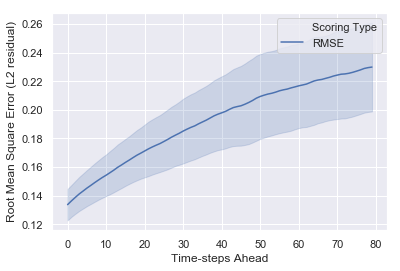

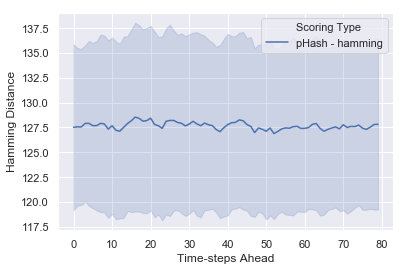

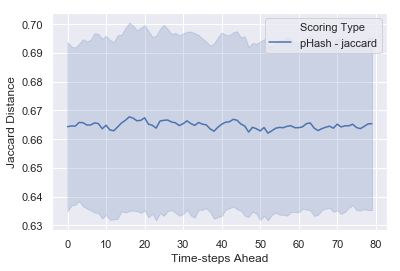

In [26]:
score_keeper2.plot()

In [151]:
m = 0
s = 0
for t in train_dataloader:
    m += t['image'].mean()
    s += t['image'].sum()

In [145]:
t = next(iter(train_dataloader))

In [150]:
t['image'].sum()

tensor(13086705.)

In [29]:
print(list(train_dataset.imagesets.size()))
print(train_dataset.train_data.float().mean()/255)
print(train_dataset.train_data.float().std()/255)

AttributeError: 'list' object has no attribute 'size'